<a href="https://colab.research.google.com/github/Juliaroch/Ironhack-final-project-Julia-Roch/blob/master/TrainCNN_RN50_50TE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib 
import matplotlib.pyplot as plt
import random
from sklearn import metrics
from sklearn.metrics import *
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(1)

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#Import the images from 11 artists I need for my training
images_dir = '/content/gdrive/My Drive/Final_project_data/resized_train_test'
data_artists = pd.read_csv('/content/gdrive/My Drive/Final_project_data/data_artists.csv')
artists_dirs = os.listdir(images_dir)
artists_top_name = data_artists['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))


Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Vincent_van_Gogh
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pablo_Picasso
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pierre-Auguste_Renoir
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Francisco_Goya
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Albrecht_Dürer
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Alfred_Sisley
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Marc_Chagall
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Edgar_Degas
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Rembrandt
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Titian
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Paul_Gauguin


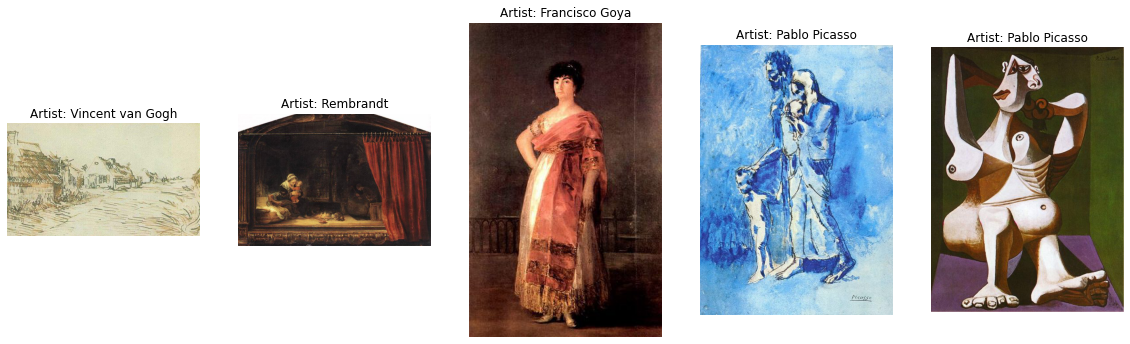

In [5]:
#See if images have been imported correctly 
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [6]:
#Train_test_split
batch_size = 32
train_input_shape = (128, 128, 3)
n_classes = artists_top_name.shape[0]

train_datagen=ImageDataGenerator(validation_split=0.1,rescale=1./255.,horizontal_flip=True,vertical_flip=True)
                                 
train_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="training",shuffle=True,classes=artists_top_name.tolist())
                                                   
valid_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="validation",shuffle=True,classes=artists_top_name.tolist())

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2384 images belonging to 11 classes.
Found 262 images belonging to 11 classes.
Total number of batches = 74 and 8


In [0]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [0]:
X = base_model.output
X = Flatten()(X)

X = Dense(256, kernel_initializer='he_uniform')(X)
X = Dropout(0.25)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.25)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [0]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')

In [11]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr], use_multiprocessing=False, workers=16)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
74/74 [==============================] - 64s 864ms/step - loss: 1.9471 - accuracy: 0.3834 - val_loss: 3.2160 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 2/10
74/74 [==============================] - 62s 835ms/step - loss: 1.6952 - accuracy: 0.5043 - val_loss: 2.5645 - val_accuracy: 0.0957 - lr: 0.0010
Epoch 3/10
74/74 [==============================] - 63s 852ms/step - loss: 1.5297 - accuracy: 0.5625 - val_loss: 2.7992 - val_accuracy: 0.0913 - lr: 0.0010
Epoch 4/10
74/74 [==============================] - 62s 844ms/step - loss: 1.4174 - accuracy: 0.5884 - val_loss: 2.8654 - val_accuracy: 0.0783 - lr: 0.0010
Epoch 5/10
74/74 [==============================] - 63s 846ms/step - loss: 1.3156 - accuracy: 0.6165 - val_loss: 4.0002 - val_accuracy: 0.0913 - lr: 0.0010
Epoch 6/10
74/74 [==============================] - 64s 860ms/step - loss: 1.2535 - accuracy: 0.6395 - val_loss: 3.6245 - val_accuracy: 0.0870 -

In [12]:
#for layer in model.layers[:50]:
 # layer.trainable = False

for layer in model.layers[50:]:
   layer.trainable = True

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

n_epoch = 40
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr, early_stop], use_multiprocessing=False, workers=16)

Epoch 1/40
74/74 [==============================] - 57s 767ms/step - loss: 0.8234 - accuracy: 0.7738 - val_loss: 2.6663 - val_accuracy: 0.1391 - lr: 0.0010
Epoch 2/40
74/74 [==============================] - 57s 770ms/step - loss: 0.7560 - accuracy: 0.8079 - val_loss: 2.5422 - val_accuracy: 0.2739 - lr: 0.0010
Epoch 3/40
74/74 [==============================] - 57s 766ms/step - loss: 0.7134 - accuracy: 0.8142 - val_loss: 2.0071 - val_accuracy: 0.3478 - lr: 0.0010
Epoch 4/40
74/74 [==============================] - 57s 777ms/step - loss: 0.6973 - accuracy: 0.8223 - val_loss: 1.5893 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 5/40
74/74 [==============================] - 60s 806ms/step - loss: 0.6908 - accuracy: 0.8287 - val_loss: 1.2705 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/40
74/74 [==============================] - 61s 818ms/step - loss: 0.6675 - accuracy: 0.8287 - val_loss: 1.1181 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 7/40
74/74 [==============================] - 61s 820ms/st

In [0]:
#score = model.evaluate_generator(train_generator, verbose=1)
#print("Prediction accuracy on train data =", score[1])

In [0]:
#score = model.evaluate_generator(valid_generator, verbose=1)
#print("Prediction accuracy on CV data =", score[1])

In [0]:
# serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
 #   json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("/content/gdrive/My Drive/Final_project_data/modelRN50-38TE.h5")
#print("Saved model to disk")

model.save('/content/gdrive/My Drive/Final_project_data/my_model160420RNv2.h5')

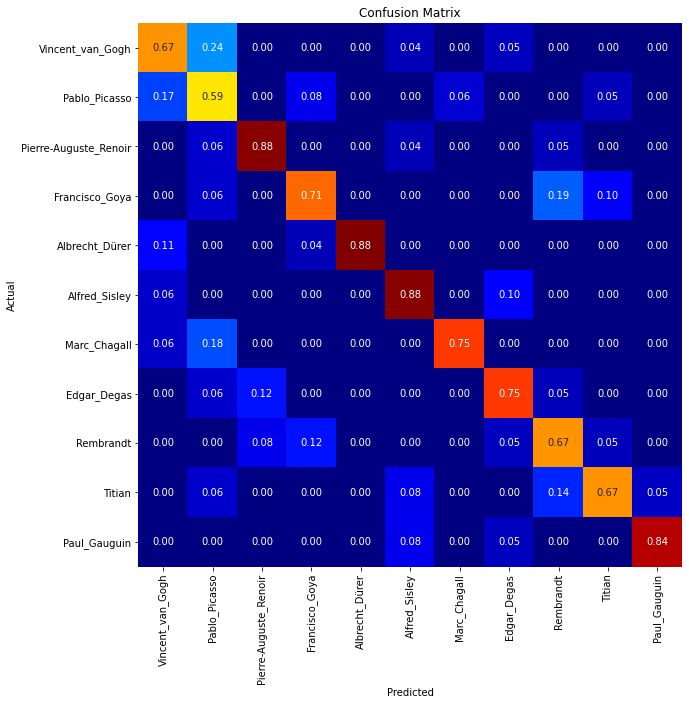

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.63      0.67      0.65        18
        Pablo_Picasso       0.48      0.59      0.53        17
Pierre-Auguste_Renoir       0.81      0.88      0.84        24
       Francisco_Goya       0.74      0.71      0.72        24
       Albrecht_Dürer       1.00      0.88      0.94        26
        Alfred_Sisley       0.78      0.88      0.82        24
         Marc_Chagall       0.92      0.75      0.83        16
          Edgar_Degas       0.75      0.75      0.75        20
            Rembrandt       0.61      0.67      0.64        21
               Titian       0.78      0.67      0.72        21
         Paul_Gauguin       0.94      0.84      0.89        19

             accuracy                           0.76       230
            macro avg       0.77      0.75      0.76       230
         weighted avg       0.77      0.76      0.76       230



In [16]:
 # Classification report and confusion matrix
tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))
    return y_pred, y_true

y_pred, y_true = showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

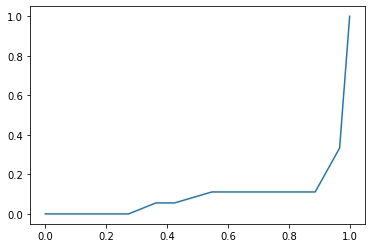

AUC: 0.09368448637316565


In [17]:
#ROC and AUC curves
y_true = y_true# true labels
y_probas = y_pred# predicted results
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)


In [18]:
#ROC and AUC scores
y_pred_keras = y_pred
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras, pos_label=0)

auc_keras = auc(fpr_keras, tpr_keras)
print(fpr_keras, tpr_keras, thresholds_keras)
print(auc_keras)

TypeError: ignored

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred, multi_class='ovo')